In [1]:
# !pip install bitermplus
# !pip install tmplot

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import bitermplus as btm
import numpy as np
import pandas as pd
import pickle as pkl

from deep_translator import GoogleTranslator
from deep_translator.exceptions import NotValidPayload
def gtranslate(words, src='auto', lang='en') :
    translator = GoogleTranslator(source=src, target=lang)
    res=[]
    for w in words :
        try :
            translated=translator.translate(w)
            res.append(translated)
        except NotValidPayload :
            res.append(w)
    return(res)



In [2]:
from deep_translator import GoogleTranslator
from deep_translator.exceptions import NotValidPayload
def gtranslate(words, src='auto', lang='en') :
    translator = GoogleTranslator(source=src, target=lang)
    res=[]
    translated=translator.translate_batch(words)
    # for w in words :
    #     try :
    #         translated=translator.translate(w)
    #         res.append(translated)
    #     except NotValidPayload :
    #         res.append(w)
    return(translated)

In [57]:
# IMPORT FONCTION DE PRE PROCESS D'ORIGINE
import re
def roberta_preprocess(text):
    new_text = []
    for t in text.split():
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 'http', str(t))
        new_text.append(t)
    return " ".join(new_text)
# pr sélection des docs, cf papier :
                            # To reduce lowquality
                            # tweets, we processed the raw content via the following
                            # normalization steps: (a) removing non-Latin characters
                            # and stop words; (b) converting letters into lower case; (c)
                            # removing words with document frequency less than 10; (d)
                            # filtering out tweets with length less than 2; (e) removing duplicate
                            # tweets.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def vectorize(docs, preprocessed_docs_tmp) :
    # On choisit la taille du vocabulaire
    vocabulary_size=10000
    # Extraction des mots les plus importants via matrice terme-document
    # On peut tester avec un tf-idf
    # Ou des n-grams
    # vectorizer = CountVectorizer(ngram_range=(1,3), max_features=vocabulary_size)
    vectorizer = CountVectorizer(max_features=vocabulary_size, max_df=0.99, min_df=5)

    vectorizer.fit_transform(preprocessed_docs_tmp)
    vocabulary = set(vectorizer.get_feature_names())
    preprocessed_docs_tmp = [' '.join([w for w in doc.split() if w in vocabulary])
                                  for doc in preprocessed_docs_tmp]


    preprocessed_docs, unpreprocessed_docs, deleted = [], [], []


    for i, doc in enumerate(preprocessed_docs_tmp):
        if len(doc) > 0:
            preprocessed_docs.append(doc)
            # Renvoie la liste des mêmes documents, non traités, pour BERT
            # pour les textes destinés à BERT on va quand même retirer les liens, les emoji... ?
            # unpreprocessed_docs.append(' '.join(remove_html(remove_emoji(docs[i]))).split())
            # test avec la fonction pour le modèle roberta-xlm-twitter
            unpreprocessed_docs.append(roberta_preprocess(docs[i]))
            # Renvoie une liste de booléens pour repérer les tweets supprimés (car vides) après preproc
            deleted.append(0)
        else :
            deleted.append(1)

    return preprocessed_docs, unpreprocessed_docs, list(vocabulary), deleted



In [ ]:

# LOAD MODELS
langs = ['russian', 'english']
results=dict.fromkeys(langs)
model_runs = 3
for lang in langs :
    # IMPORTING DATA
    results[lang]={}
    metrics = {'n_topics':[], 'coherence':[], 'perplexity':[], }
    results[lang]['models']=[]
    for i, n_topics in enumerate(range (5,25)) :
        for r in range (model_runs) :
            print(f'run {r} for {n_topics} topics')
            # INITIALIZING AND RUNNING MODEL
            # model = btm.BTM(
            #     X, vocabulary, seed=12321, T=n_topics, M=20, alpha=50/n_topics, beta=0.01, has_background=True)
            model = btm.BTM(
                X, vocabulary, T=n_topics, M=20, alpha=50/n_topics, beta=0.01, has_background=True)
            model.fit(biterms, iterations=50)
            p_zd = model.transform(docs_vec)
            # METRICS
            perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, 8)
            coherence = btm.coherence(model.matrix_topics_words_, X, M=10)
            metrics['n_topics'].append(n_topics)
            metrics['coherence'].append(coherence)
            metrics['perplexity'].append(perplexity)
            results[lang]['models'].append(model)
            with open(f"bench/results/B7_10k_095_POS/Biterm/{lang}/models/{i}_{r}.pkl", "wb") as file:
                pkl.dump(model, file)
    
    results[lang]['metrics']=metrics
    metrics_df=pd.DataFrame(metrics)
    metrics_df.to_csv(f"bench/results/B7_10k_095_POS/Biterm/{lang}/results.csv")

    

In [4]:
from nlp_preprocess import preprocess

In [ ]:
# MODEL RUNS new data
langs = ['russian', 'english']
results=dict.fromkeys(langs)
model_runs = 3
for lang in langs :
    # IMPORTING DATA
    results[lang]={}
    df=pd.read_csv('datasets/beltweets_nlp_test/aug01_31_' + lang + '.csv')
    df=df.dropna(subset=["lemmatized_POS"])
    preprocessed_docs, unpreprocessed_docs, vocab, deleted = vectorize(df['text'].str.strip().to_list(), df['lemmatized_POS'].str.strip().to_list())
    df['deleted']=deleted
    df['deleted']=df['deleted'].astype(bool)
    df=df[[c for c in df.columns if c not in ['preproc', 'unpreproc']]]
    df.loc[~df.deleted, 'preproc']=preprocessed_docs
    df.loc[~df.deleted, 'unpreproc']=unpreprocessed_docs
    df=df.drop_duplicates(subset=['preproc'], keep='first')
    texts=df[~df.deleted]['preproc'].str.strip().tolist()
    # IMPORT DATA FROM OCTIS .TSV
    # df = pd.read_csv(
    #     f'datasets/LDA_10k_095_POS/aug01_31/{lang}/corpus.tsv', sep='\t', header=None)
    # # df=df.drop_duplicates(keep='first')
    # texts = df[0].str.strip().tolist()
    #
    results[lang]['orig_df']=df
    results[lang]['texts']=texts
    # PREPROCESSING
    # Obtaining terms frequency in a sparse matrix and corpus vocabulary
    X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
    tf = np.array(X.sum(axis=0)).ravel()
    # Vectorizing documents
    docs_vec = btm.get_vectorized_docs(texts, vocabulary)
    docs_lens = list(map(len, docs_vec))
    # Generating biterms
    biterms = btm.get_biterms(docs_vec)
    # Creating dict for the metrics
    metrics = {'n_topics':[], 'coherence':[], 'perplexity':[]}
    results[lang]['models']=[]
    for i, n_topics in enumerate(range (5,25)) :
        for r in range (model_runs) :
            print(f'run {r} for {n_topics} topics')
            # INITIALIZING AND RUNNING MODEL
            # model = btm.BTM(
            #     X, vocabulary, seed=12321, T=n_topics, M=20, alpha=50/n_topics, beta=0.01, has_background=True)
            model = btm.BTM(
                X, vocabulary, T=n_topics, M=20, alpha=50/n_topics, beta=0.01, has_background=True)
            model.fit(biterms, iterations=50)
            p_zd = model.transform(docs_vec)
            # METRICS
            perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, 8)
            coherence = btm.coherence(model.matrix_topics_words_, X, M=10)
            metrics['n_topics'].append(n_topics)
            metrics['coherence'].append(coherence)
            metrics['perplexity'].append(perplexity)
            results[lang]['models'].append(model)
            with open(f"bench/results/B7_10k_095_POS/Biterm/{lang}/models/{i}_{r}.pkl", "wb") as file:
                pkl.dump(model, file)
    
    results[lang]['metrics']=metrics
    metrics_df=pd.DataFrame(metrics)
    metrics_df.to_csv(f"bench/results/B7_10k_095_POS/Biterm/{lang}/results.csv")

    

In [ ]:
# MODEL RUNS
langs = ['russian', 'english']
results=dict.fromkeys(langs)
model_runs = 3
for lang in langs :
    # IMPORTING DATA
    results[lang]={}
    df=pd.read_csv('bench/orig_datasets/LDA_10k_095_POS/aug01_31_' + lang + '.csv', lineterminator='\n')
    df=df.dropna(subset=["lemmatized_POS"])
    preprocessed_docs, unpreprocessed_docs, vocab, deleted = vectorize(df['text'].str.strip().to_list(), df['lemmatized_POS'].str.strip().to_list())
    df['deleted']=deleted
    df['deleted']=df['deleted'].astype(bool)
    df=df[[c for c in df.columns if c not in ['preproc', 'unpreproc']]]
    df.loc[~df.deleted, 'preproc']=preprocessed_docs
    df.loc[~df.deleted, 'unpreproc']=unpreprocessed_docs
    df=df.drop_duplicates(subset=['preproc'], keep='first')
    texts=df[~df.deleted]['preproc'].str.strip().tolist()
    # IMPORT DATA FROM OCTIS .TSV
    # df = pd.read_csv(
    #     f'datasets/LDA_10k_095_POS/aug01_31/{lang}/corpus.tsv', sep='\t', header=None)
    # # df=df.drop_duplicates(keep='first')
    # texts = df[0].str.strip().tolist()
    #
    results[lang]['orig_df']=df
    results[lang]['texts']=texts
    # PREPROCESSING
    # Obtaining terms frequency in a sparse matrix and corpus vocabulary
    X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
    tf = np.array(X.sum(axis=0)).ravel()
    # Vectorizing documents
    docs_vec = btm.get_vectorized_docs(texts, vocabulary)
    docs_lens = list(map(len, docs_vec))
    # Generating biterms
    biterms = btm.get_biterms(docs_vec)
    # Creating dict for the metrics
    metrics = {'n_topics':[], 'coherence':[], 'perplexity':[]}
    results[lang]['models']=[]
    for i, n_topics in enumerate(range (5,25)) :
        for r in range (model_runs) :
            print(f'run {r} for {n_topics} topics')
            # INITIALIZING AND RUNNING MODEL
            # model = btm.BTM(
            #     X, vocabulary, seed=12321, T=n_topics, M=20, alpha=50/n_topics, beta=0.01, has_background=True)
            model = btm.BTM(
                X, vocabulary, T=n_topics, M=20, alpha=50/n_topics, beta=0.01, has_background=True)
            model.fit(biterms, iterations=50)
            p_zd = model.transform(docs_vec)
            # METRICS
            perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, 8)
            coherence = btm.coherence(model.matrix_topics_words_, X, M=10)
            metrics['n_topics'].append(n_topics)
            metrics['coherence'].append(coherence)
            metrics['perplexity'].append(perplexity)
            results[lang]['models'].append(model)
            with open(f"bench/results/B7_10k_095_POS/Biterm/{lang}/models/{i}_{r}.pkl", "wb") as file:
                pkl.dump(model, file)
    
    results[lang]['metrics']=metrics
    metrics_df=pd.DataFrame(metrics)
    metrics_df.to_csv(f"bench/results/B7_10k_095_POS/Biterm/{lang}/results.csv")

    

In [2]:
# n_topics 15, has_bg=true fonctionne assez bien

In [12]:
btm.coherence(model.matrix_topics_words_, X, M=10)

array([-112.78544523, -137.94384444, -125.65148341, -131.11742716,
       -132.21447895, -140.93074298, -140.9750447 , -128.77170686,
       -131.06819144, -136.36513058, -134.29654914, -146.348373  ,
       -118.39943318, -106.08258964, -116.49522715, -123.81981128,
       -126.83042269, -111.79487015, -116.04106451, -121.81202756,
       -127.01122337, -121.93715237, -131.63270138, -132.86934741])

In [ ]:
if lang=='russian' :
    model_ru=model
else :
    model_en=model

In [10]:
len(vocabulary)

5925

In [30]:
ya.iloc[0][0]

'[-115.36176379 -130.97431206 -111.61141389 -145.51671397 -128.95623727]'

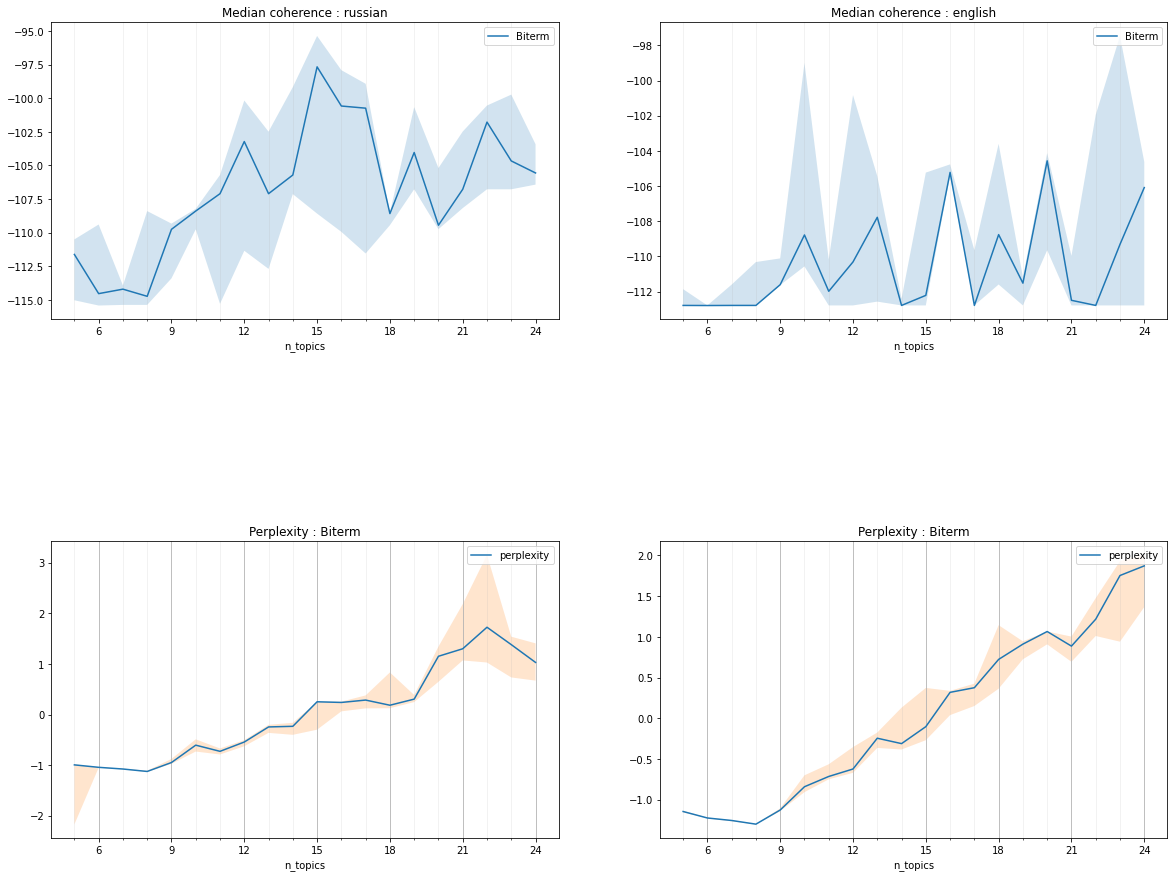

In [31]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
basepath='/B7_10k_095_POS/'
resultpath = 'bench/results'+basepath
datasetpath='datasets/LDA_10k_095_POS/aug01_31/'
langs=['russian', 'english']
tocompare=[['Biterm'], ['Biterm']]
fig, axs = plt.subplots(len(tocompare[0])+1, len(tocompare), figsize=(20,15))
for u, (lang, models) in enumerate(zip(langs, tocompare)):
    dfs = [pd.read_csv(resultpath +c +'/'+ lang + '/results.csv', index_col=0).set_index('n_topics') for c in tocompare[u]]
    axs[0, u].set_title('Median coherence : '+lang)
    for i, df in enumerate(dfs) :
        norm_df = ((df-df.mean())/df.std())
        norm_df.groupby(norm_df.index).median().plot(ax=axs[i+1, u]);
        for metric in norm_df.columns :
            ymin=norm_df.groupby(norm_df.index)[metric].min()
            ymax=norm_df.groupby(norm_df.index)[metric].max()
            axs[i+1, u].fill_between(norm_df.index.drop_duplicates(), ymin, ymax, alpha=0.2)
        df['coherence'].apply
        ya=df.groupby(df.index)['coherence'].apply(lambda x: np.fromstring(x))
        ymin=df.groupby(df.index)['coherence'].min()
        ymax=df.groupby(df.index)['coherence'].max()
        ya.plot(ax=axs[0, u])
        axs[0, u].fill_between(df.index.drop_duplicates(), ymin, ymax, alpha=0.2)
        

        axs[i+1, u].xaxis.grid(True)
        minor_ticks=(df.index.drop_duplicates().values)
        # minor_ticks=np.arange(min(df.index.values), max(df.index.values))
        axs[i+1, u].set_xticks(minor_ticks, minor=True);
        axs[i+1, u].xaxis.grid(which='minor', alpha=0.2)
        axs[i+1, u].set_title('Coherence vs diversity : '+tocompare[u][i])
        axs[i+1, u].xaxis.set_major_locator(MaxNLocator(integer=True))
        
    axs[0, u].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0, u].legend(labels= tocompare[u]);
    axs[0, u].set_xticks(minor_ticks, minor=True);
    axs[0, u].xaxis.grid(which='minor', alpha=0.2)
    fig.subplots_adjust(hspace=0.75)

In [12]:
for lang, model in [('english', model_en), ('russian', model_ru)] :
    print(lang.upper()+'__________')
    tops=btm.get_top_topic_words(model, 30)
    for c in tops.columns :
        if c=='topic0' :
            top_unique_w = tops[c].to_list()[:10]
        else :
            # remove words from this topic if they appear in top 10 words of other topics
            othertops = [' '.join(t) for t in [tops[u].to_list()[:10] for u in tops.columns if u != c]]
            other_topic_w = list(dict.fromkeys(' '.join(othertops).split()))
            top_unique_w = [w for w in tops[c].to_list() if w not in other_topic_w]
        
        if lang=='russian' :
            print(c, (*top_unique_w), '\n', gtranslate(top_unique_w))
        else :
            print(c, (*top_unique_w))

ENGLISH__________
topic0 people lukashenko protest election belarusprotest police belarusian protester belarusprot support
topic1 torture peaceful detain release arrest detention demand human authority stop brutality prisoner brutal jail
topic2 sanction foreign official government impose work authority need international statement responsible member minister stop include
topic3 beat man know happen take year kill old arrest want need find ask
topic4 strike worker factory join plant work tv demand company leave employee tractor new chant away belarussolidarity
topic5 see time get make good look year last happen well come think change take hope many even thing still want
topic6 situation political new statement dialogue take need discuss democratic
topic7 vote result presidential rig tsikhanouskaya candidate new tikhanovskaya president fair poll belaruspresidentialelection official victory free win claim follow
topic8 today flag rally thousand solidarity white take gather chain city show

In [ ]:
# If we don't care about "BG topic" and similar words between topics
# for lang, model in [('english', model_en), ('russian', model_ru)] :
#     print(lang.upper()+'__________')
#     for c in btm.get_top_topic_words(model, 15).columns :
#         if lang=='russian' :
#             print(c, (*btm.get_top_topic_words(model, 15)[c].to_list()), '\n', gtranslate(btm.get_top_topic_words(model, 20)[c].to_list()))
#         else :
#             print(c, (*btm.get_top_topic_words(model, 15)[c].to_list()))

In [ ]:
# import pickle as pkl
# import tmplot as tmp
# import glob

# # # Loading saved models
# # models_files = sorted(glob.glob(r'results/model[0-9].pkl'))
# # models = []
# # for fn in models_files:
# #     file = open(fn, 'rb')
# #     models.append(pkl.load(file))
# #     file.close()

# # Choosing reference model
# np.random.seed(122334)
# reference_model = np.random.randint(1, 6)

# # Getting close topics
# close_topics, close_kl = tmp.get_closest_topics(
#     models, method="sklb", ref=reference_model)

# # Getting stable topics
# stable_topics, stable_kl = tmp.get_stable_topics(
#     close_topics, close_kl, ref=reference_model, thres=0.7)

# # Stable topics indices list
# print(stable_topics[:, reference_model])

In [ ]:
# # LOAD
# with open("model.pkl", "rb") as file:
#     model = pkl.load(file)

In [ ]:
# # METRICS
# perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, 8)
# coherence = btm.coherence(model.matrix_topics_words_, X, M=20)
# # or
# perplexity = model.perplexity_
# coherence = model.coherence_

In [ ]:
# import tmplot as tmp

# # Run the interactive report interface
# tmp.report(model=model_ru, docs=results['russian']['texts'])

In [58]:
data=pd.read_csv('datasets/beltweets_nlp_RT.csv')
data['created_at']=pd.to_datetime(data['created_at'])
data['status_id']=data['status_id'].astype(str).replace('nan', np.nan)
data['retweet_status_id']=data['retweet_status_id'].astype('Int64').astype(str).replace('<NA>', np.nan)
data['orig_tweet_id']=data[['retweet_status_id', 'status_id']].apply(lambda x: x['retweet_status_id'] if pd.notnull(x['retweet_status_id']) else x['status_id'], axis=1)

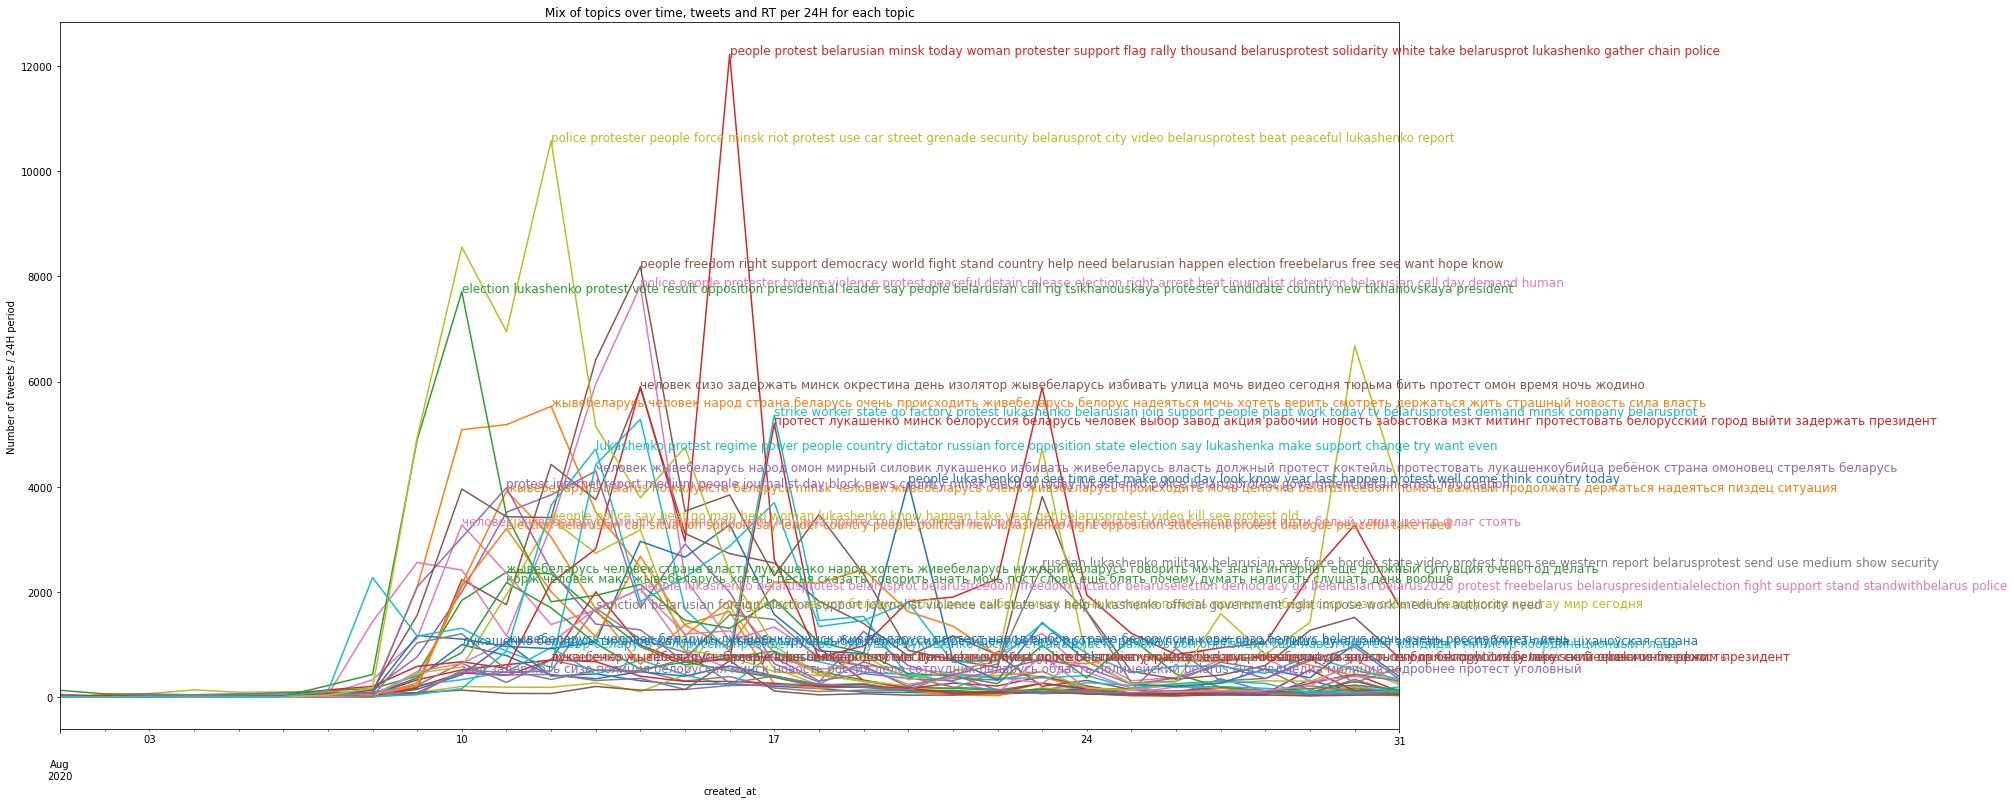

In [15]:
import matplotlib.pyplot as plt
toplot = zip(langs, [model_ru, model_en])
freq='24H'
for lang, m in toplot :
    # df=pd.read_csv('bench/orig_datasets/LDA_10k_095_POS/aug01_31_' + lang + '.csv', lineterminator='\n')
    df = results[lang]['orig_df']
    df = df.dropna(subset=['deleted'])
    # df=df.drop_duplicates(subset=['preproc'])
    df.loc[~df.deleted, 'best_topic']=m.labels_
    df['best_topic']=df['best_topic'].astype('Int64')
    # tops=btm.get_top_topic_words(m, 15)
    # Compute top topic, top topic words, top topic unique words
    tops=btm.get_top_topic_words(m, 30)
    l_topics_uniques=[]
    for c in tops.columns :
        if c=='topic0' :
            top_unique_w = tops[c].to_list()[:10]
        else :
            othertops = [' '.join(t) for t in [tops[u].to_list()[:10] for u in tops.columns if u != c]]
            other_topic_w = list(dict.fromkeys(' '.join(othertops).split()))
            top_unique_w = [w for w in tops[c].to_list() if w not in other_topic_w]
            
        l_topics_uniques.append('***'.join([topic_word for topic_word in top_unique_w]))
    l_topics=['***'.join(tops.iloc[:,x].to_list()) for x in range(len(tops.columns))]
    df.loc[df['best_topic'].notna(),'topic_words']=df.loc[df['best_topic'].notna()]['best_topic'].apply(lambda x: l_topics[x])
    df.loc[df['best_topic'].notna(),'topic_unique_words']=df.loc[df['best_topic'].notna()]['best_topic'].apply(lambda x: l_topics_uniques[x])
    # Join best topics (no topic distrib) to the lang DF
    df['status_id']=df['status_id'].astype(str).replace('<NA>', np.nan)
    df=data[data.lang==lang[:2]].join(df.set_index('status_id')[['preproc', 'best_topic', 'topic_words', 'topic_unique_words', 'deleted']], on='orig_tweet_id')
    df['hashtags']=df['hashtags'].apply(lambda x : '***'.join(eval(x)) if isinstance(x, str) and isinstance(eval(x), list) else x)
    results[lang]['for_cortext']=df.dropna(subset=['best_topic'])[[c for c in df.columns if c not in ['description', '_meta', 'mean_freq', 'name', 'RT_to_tweets', 'orig_tweet_id']]]\
        .set_index('status_id').sort_values('created_at')
    results[lang]['for_cortext']=results[lang]['for_cortext'].dropna(subset=['deleted'])
    # results[lang]['for_cortext']= results[lang]['for_cortext'] [  ~results[lang]['for_cortext']['created_at'].str.contains(r'[a-z][A-Z]')  ]
    results[lang]['for_cortext']= results[lang]['for_cortext'].dropna(subset=['user_id'])
    results[lang]['for_cortext']['date_day']=results[lang]['for_cortext'].created_at.dt.strftime('%Y-%m-%d')
    results[lang]['for_cortext']['text']=results[lang]['for_cortext']['text'].str.replace("\r\n","")
    results[lang]['for_cortext']['text']=results[lang]['for_cortext']['text'].str.replace("\r","")
    results[lang]['for_cortext'].to_csv('for_cortext_'+lang+'.csv')
    for n in range(m.topics_num_) :
        g=df[['created_at', 'best_topic']][(df['created_at'].dt.date>=pd.Timestamp(2020,8,1)) & (df['created_at'].dt.date<=pd.Timestamp(2020,8,31))& (df["best_topic"]==n)].groupby(\
        pd.Grouper(key='created_at', freq=freq, convention='start')).size()
        p=g.plot(figsize=(24,13))
        y=g.max()
        x=g.idxmax()
        # plt.text(x,y, s=linebreak(bel_top_retweets['text'].iloc[0]), color=p.lines[-1].get_color())
        plt.annotate(text=' '.join(btm.get_top_topic_words(m, 20)[f'topic{n}']), xy=(x,y), fontsize=12, color=p.lines[-1].get_color())   #Try add   #, wrap=True)
plt.title("Mix of topics over time, tweets and RT per "+freq+ " for each topic");
plt.ylabel('Topic number');
plt.ylabel(f'Number of tweets / {freq} period');
    

In [ ]:
print(g.reset_index()[0].to_json(orient='records'))

In [ ]:
df_allcounts=df[['created_at', 'best_topic']][(df['created_at'].dt.date>=pd.Timestamp(2020,8,1)) & (df['created_at'].dt.date<=pd.Timestamp(2020,8,31))& (df["best_topic"]==0)].groupby(\
        pd.Grouper(key='created_at', freq=freq, convention='start')).size()
for n in range(m.topics_num_)[1:] :
    df_allcounts=df_allcounts.merge(df[['created_at', 'best_topic']][(df['created_at'].dt.date>=pd.Timestamp(2020,8,1)) & (df['created_at'].dt.date<=pd.Timestamp(2020,8,31))& (df["best_topic"]==n)].groupby(\
        pd.Grouper(key='created_at', freq=freq, convention='start')).size(), on='created_at')

In [30]:
df_en= pd.read_csv('for_cortext_english.csv')

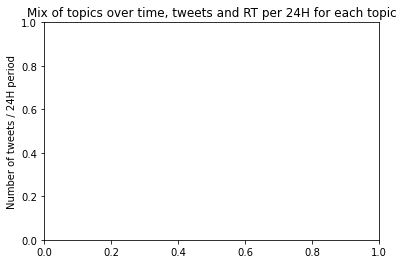

In [185]:
# TOP COUNTS ONLY
import matplotlib.pyplot as plt
toplot = zip(langs, [model_ru, model_en])
freq='24H'
for lang, m in toplot :
    # df=pd.read_csv('bench/orig_datasets/LDA_10k_095_POS/aug01_31_' + lang + '.csv', lineterminator='\n')
    df = results[lang]['orig_df']
    df = df.dropna(subset=['deleted'])
    # df=df.drop_duplicates(subset=['preproc'])
    df.loc[~df.deleted, 'best_topic']=m.labels_
    df['best_topic']=df['best_topic'].astype('Int64')
    # tops=btm.get_top_topic_words(m, 15)
    # Compute top topic, top topic words, top topic unique words
    tops=btm.get_top_topic_words(m, 30)
    l_topics_uniques=[]
    for c in tops.columns :
        if c=='topic0' :
            top_unique_w = tops[c].to_list()[:10]
        else :
            othertops = [' '.join(t) for t in [tops[u].to_list()[:10] for u in tops.columns if u != c]]
            other_topic_w = list(dict.fromkeys(' '.join(othertops).split()))
            top_unique_w = [w for w in tops[c].to_list() if w not in other_topic_w]
            
        l_topics_uniques.append('***'.join([topic_word for topic_word in top_unique_w]))
    l_topics=['***'.join(tops.iloc[:,x].to_list()) for x in range(len(tops.columns))]
    df.loc[df['best_topic'].notna(),'topic_words']=df.loc[df['best_topic'].notna()]['best_topic'].apply(lambda x: l_topics[x])
    df.loc[df['best_topic'].notna(),'topic_unique_words']=df.loc[df['best_topic'].notna()]['best_topic'].apply(lambda x: l_topics_uniques[x])
    
    # ORIG
     # Join best topics (no topic distrib) to the lang DF
    df['status_id']=df['status_id'].astype(str).replace('<NA>', np.nan)
    df=data[data.lang==lang[:2]].join(df.set_index('status_id')[['preproc', 'best_topic', 'topic_words', 'topic_unique_words', 'deleted']], on='orig_tweet_id')
    
    # WITH TOP 500 RT
    # # Join best topics (no topic distrib) to the lang DF
    # df['status_id']=df['status_id'].astype(str).replace('<NA>', np.nan)
    # # Join the retweet_count from the large DF
    # # df['retweet_count']=data.set_index('status_id').loc[df['status_id']]['retweet_count']
    # df=df.join(data.set_index('status_id')[['created_at', 'n_tweets', 'retweet_count']], on='status_id')
    # # # Keep only the top retweeted tweets
    # df=df.sort_values('n_tweets', ascending=False).sort_values('retweet_count', ascending=False).groupby(pd.to_datetime(df['created_at']).dt.date).head(500)
    # # Join this subset to the large DF, mapping to retweets this time
    # df=data[data.lang==lang[:2]].join(df.set_index('status_id')[['preproc', 'best_topic', 'topic_words', 'topic_unique_words', 'deleted']], on='orig_tweet_id')
    
    
    df['hashtags']=df['hashtags'].apply(lambda x : '***'.join(eval(x)) if isinstance(x, str) and isinstance(eval(x), list) else x)
    results[lang]['for_cortext']=df.dropna(subset=['best_topic'])[[c for c in df.columns if c not in ['description', '_meta', 'mean_freq', 'name', 'RT_to_tweets', 'orig_tweet_id']]]\
        .set_index('status_id').sort_values('created_at')
    results[lang]['for_cortext']=results[lang]['for_cortext'].dropna(subset=['deleted'])
    # results[lang]['for_cortext']= results[lang]['for_cortext'] [  ~results[lang]['for_cortext']['created_at'].str.contains(r'[a-z][A-Z]')  ]
    results[lang]['for_cortext']= results[lang]['for_cortext'].dropna(subset=['user_id'])
    results[lang]['for_cortext']['date_day']=results[lang]['for_cortext'].created_at.dt.strftime('%Y-%m-%d')
    results[lang]['for_cortext']['nth_day']=results[lang]['for_cortext'].reset_index().index.values+1
    results[lang]['for_cortext']['text']=results[lang]['for_cortext']['text'].str.replace("\r\n","")
    results[lang]['for_cortext']['text']=results[lang]['for_cortext']['text'].str.replace("\r","")
    df5=results[lang]['for_cortext']
    df5=df5.set_index(df5['created_at'], drop=False)[:"2020-08-31"]
    df5=df5.groupby(df5['created_at'].dt.date)['topic_unique_words'].value_counts(normalize=True)\
        .unstack().fillna(0).reset_index().melt(id_vars='created_at', value_vars=df5.topic_unique_words.value_counts().index, var_name='topic_unique_words', value_name='count')
    
    # results[lang]['for_cortext'].to_csv('top500_RT_'+lang+'.csv')
    # Plot the count for each value of best_topic
    # for n in range(m.topics_num_) :
    #     g=df[['created_at', 'best_topic']][(df['created_at'].dt.date>=pd.Timestamp(2020,8,1)) & (df['created_at'].dt.date<=pd.Timestamp(2020,8,31))& (df["best_topic"]==n)].groupby(\
    #     pd.Grouper(key='created_at', freq=freq, convention='start')).size()
    #     p=g.plot(figsize=(24,13))
    #     y=g.max()
    #     x=g.idxmax()
    #     # plt.text(x,y, s=linebreak(bel_top_retweets['text'].iloc[0]), color=p.lines[-1].get_color())
    #     plt.annotate(text=' '.join(btm.get_top_topic_words(m, 20)[f'topic{n}']), xy=(x,y), fontsize=12, color=p.lines[-1].get_color())   #Try add   #, wrap=True)
plt.title("Mix of topics over time, tweets and RT per "+freq+ " for each topic");
plt.ylabel('Topic number');
plt.ylabel(f'Number of tweets / {freq} period');
    

In [181]:
df5

,created_at,topic_unique_words,count
0,2020-08-01,riot***use***car***street***grenade***security...,0.050000
1,2020-08-02,riot***use***car***street***grenade***security...,0.024390
2,2020-08-03,riot***use***car***street***grenade***security...,0.080000
3,2020-08-04,riot***use***car***street***grenade***security...,0.000000
4,2020-08-05,riot***use***car***street***grenade***security...,0.000000
...,...,...,...
460,2020-08-27,people***lukashenko***protest***election***bel...,0.005357
461,2020-08-28,people***lukashenko***protest***election***bel...,0.005264
462,2020-08-29,people***lukashenko***protest***election***bel...,0.002353
463,2020-08-30,people***lukashenko***protest***election***bel...,0.001931


In [184]:
df5['topic_unique_words']

0          car
1          car
2          car
3          car
4          car
        ...   
460    protest
461    protest
462    protest
463    protest
464    protest
Name: topic_unique_words, Length: 465, dtype: object

In [192]:
df5['topic_unique_words']=df5['topic_unique_words'].str.split(r'\*\*\*').apply(lambda x: x[:7]).str.join('_')